## Sentence tokenization

In [1]:
import pandas as pd
import re
from ipynb.fs.full.sentence_collection import sentence_collection
import docx
from docx.api import Document
import glob
import os
from ipynb.fs.full.find_shortenings import read_txt

In [2]:
PATH = os.path.abspath('..\\rfej_parser\\articles\\') + '\\'

In [3]:
# sort file names
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [4]:
def count_txt_sentance_len(reg: str) -> list:
    """Get sizes of all textes that it finds in PATH with `reg` expression. Returns list of nbrs."""
    t = ''
    lengths = []
    files = [f for f in glob.glob(PATH + '*.txt') if re.findall(reg, f)]
    files.sort(key=natural_keys)
    for f in files:
        t = [read_txt(f)]
        s = sentence_collection(t)
        lengths.append(len(s))
    return lengths

In [5]:
# supress 'WARNING:root:Something went wrong while tokenizing'
import logging

logging.root.level = logging.ERROR
ann_lengths = count_txt_sentance_len(r'\d.txt')  # annotations lengths in sentances
artcls_lengths = count_txt_sentance_len(r'_a.txt')  # articles lengths in sentances
logging.root.level = logging.WARNING

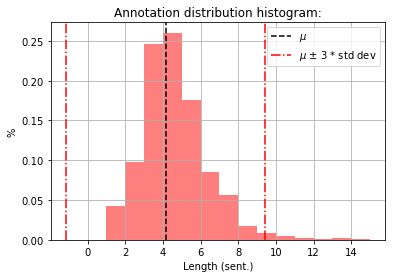

In [13]:
# Аннотации попадающие в диапазон трех среднеквадратических отклонений: 1-9 (предложений)

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import numpy as np

x = ann_lengths
n, bins, patches = plt.hist(x, bins=max(x), range=(1, max(x) + 1), normed=1, facecolor='red', alpha=0.5)
plt.axvline(np.mean(x), color='k', linestyle='--')
plt.axvline(np.mean(x) + np.std(x) * 3, color='r', linestyle='-.')
plt.axvline(np.mean(x) - np.std(x) * 3, color='r', linestyle='-.')


plt.legend([r'$\mu$', r'$\mu$ ± 3 * std dev'])
plt.xlabel('Length (sent.)')
plt.ylabel('%')
plt.title('Annotation distribution histogram:')
plt.grid(True)
plt.show()

In [70]:
# Коэффициент корреляции Пирсона меньше порога (0.2), значит линейная корреляцийя отсутствует.

from scipy.stats.stats import pearsonr
cf = pearsonr(ann_lengths, artcls_lengths)
print(cf[0])

0.0978426174088


In [89]:
# Анализ нормальности распределения данных
# Коэфф. значимости (pvalue) < 0.2, по критерию Колмогорова.
# Гипотеза о нормальности распределения данных отклюняется.
# Распределение является ассиметричным, тк коеэфф. ассиметрии < 1, и кэефф. эксцесса < 1. 

from scipy.stats import skew, kurtosis, kstest
import math

# N = len(x)
# stndrt_skew_error = math.sqrt((6 * N * (N - 1)) / ((N - 2) * (N + 1) * (N + 3)))
# stndrt_kurtosis_error = math.sqrt((4 * (N**2 - 1) * stndrt_skew_error**2) / ((N - 3) * (N + 5)))
# print(stndrt_skew_error, stndrt_kurtosis_error)
# # Проверка
# print((stndrt_skew_error / skew(x)) >= 3, (stndrt_kurtosis_error / kurtosis(x)) >= 3)
print(kstest(np.array(x), 'norm', args=(np.mean(x), np.std(x))))

KstestResult(statistic=0.17380253126783041, pvalue=0.0)


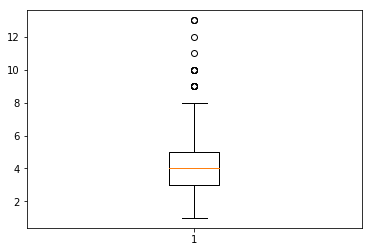

In [66]:
# Диаграмма размаха
plt.boxplot(x)
plt.show()

In [ ]:
# BOXPLOT analysis 
TODO

___

## Part of speech

In [7]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [82]:
from natasha import (
    Segmenter,
    MorphVocab,
    NewsEmbedding,
    NewsMorphTagger,
    NewsNERTagger,
    
    PER,
    NamesExtractor,
    DatesExtractor,
    MoneyExtractor,
    AddrExtractor,
    
    Doc
)

segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
ner_tagger = NewsNERTagger(emb)

# names_extractor = NamesExtractor(morph_vocab)

dates_extractor = DatesExtractor(morph_vocab)
money_extractor = MoneyExtractor(morph_vocab)
addr_extractor = AddrExtractor(morph_vocab)

In [83]:
def split_words_in_ann() -> list:
    """Get all words from annotations. Return it in one list.
    """
    files = [f for f in glob.glob(PATH + '*.txt') if re.findall(r'\d.txt', f)]
    annotations = []
    for annotation in files:
        text = read_txt(annotation)
        annotations.append(text)
    annotations = ' '.join(annotations)
    doc = Doc(annotations)
    doc.segment(segmenter)
    words = [word.text for word in doc.tokens]
    return words, doc

In [84]:
def count_words(words: list) -> list:
    """For each word get POS and add it in list.
    """ 
    pos = []
    for wd in words:
        p = morph.parse(wd)[0]
        pos.append(p.tag.POS)
    return pos

In [100]:
morph.parse('неожиданная')[0].normal_form

'неожиданный'

In [85]:
wrds, doc = split_words_in_ann()
pos_statistic = count_words(wrds)

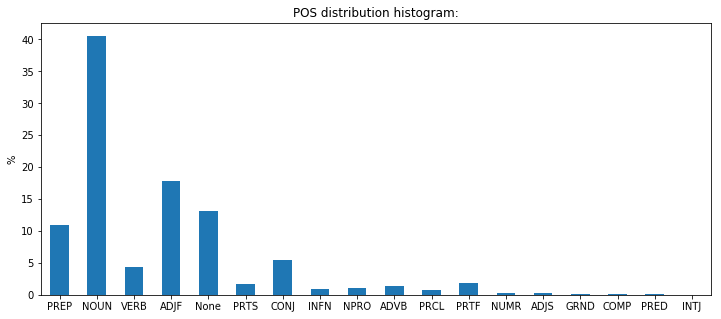

In [86]:
# Гистограмма по частям речи
# Cлужебных частей речи мало в аннотациях. Мало глаголов и прилагательных, но много существительных 

import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

words_counts = Counter(pos_statistic)
df = pd.DataFrame.from_dict(words_counts, orient='index')
df[0] = 100 * df[0] / df[0].sum()
df.plot(
    kind='bar', figsize=(12, 5), title='POS distribution histogram:', 
    rot=0.5, legend=None
)
plt.ylabel("%")
plt.show()

___

## NER

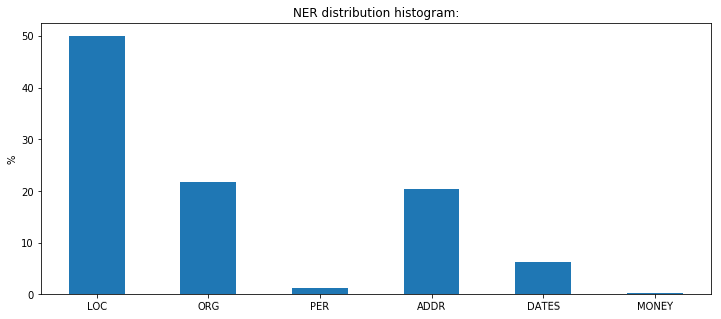

In [87]:
# Извлечение именованных сущностей (NER)
# Преобладают локации (города, страны и т.д.) и организации/группы.

# Extract standart named entities
doc.tag_ner(ner_tagger)
LOC_ORG_PER = [word.type for word in doc.spans]
# Additional entities 
# !! Числовые значения вычислены заранее на Colab
addr = ['ADDR'] * 947  # ['ADDR' for word in addr_extractor(doc.txt)]
money = ['MONEY'] * 13  # ['MONEY' for word in addr_extractor(doc.txt)]
dates = ['DATES'] * 295  # ['DATES' for word in addr_extractor(doc.txt)]
# Hist
words_counts = Counter(LOC_ORG_PER + addr + dates + money)
df = pd.DataFrame.from_dict(words_counts, orient='index')
df[0] = 100 * df[0] / df[0].sum()
df.plot(
    kind='bar', figsize=(12, 5), title='NER distribution histogram:', 
    rot=0.5, legend=None
)
plt.ylabel("%")
plt.show()